<a href="https://colab.research.google.com/github/kalakhushi18/CNN/blob/main/PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 02: Deep Neural Networks in PyTorch

At its core, PyTorch is a library for
- doing math on arrays
- with automatic calculation of gradients
- that is easy to accelerate with GPUs and distribute over nodes.

Much of the time,
we work at a remove from the core features of PyTorch,
using abstractions from `torch.nn`
or from frameworks on top of PyTorch.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd

Okay, so what next?

How do we run these neural networks on the GPU?

How do we build and load efficiently batches of data?

How do we apply data normalization?

## Training on GPU
Any data has to exist on some device. Normally our tensors live on the CPU. But when we have a GPU available we can move/copy them over to the GPU. Just like how we can transfer a tensor onto the GPU, we can also transfer the whole neural net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# what this little function does that it checks at the beginning which device we have available and then we can send in our code cells below
# everything to device and do not have to manually code which is the current running device.

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


If you are not running on a GPU instance change it in the top menu with: Runtime -> Change runtime type -> GPU

In [ ]:
#reproducibility
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed);

In [ ]:
#Let's create an example tensor and move it to gpu
test_tensor = torch.tensor([2,0,2])
print(f"Tensor currently lives on {test_tensor.device}")
#we can move it to the cpu like this
test_tensor = test_tensor.to(device)
print(f"Tensor currently lives on {test_tensor.device}")

Tensor currently lives on cpu
Tensor currently lives on cuda:0


## CIFAR10

In this notebook we use a more advanced dataset than the MNIST dataset of the last notebook.
The CIFAR10 dataset contains 10 different classes of images in a low-resolution representation of the respective objects or creatures.

In [3]:
# Here we load our CIFAR Dataset again but we add the transform argument so that during loading the CIFAR10 PIL Images \
# are directly converted to PyTorch Tensors and normalized with their dataset specific values. \
# We could compute these on our own but other people have already done that so there is no advantage to do it here on our own.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # CIFAR10 specific normalization values

batch_size = 16
# load CIFAR10 Training dataset into a PyTorch Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# wrap train_dataset into a dataloader for automatic batch generation and shuffling
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:01<00:00, 88.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


The DataLoader class does not work like the DataSet class. For example we can not index the DataLoader

In [ ]:
trainloader[0]

TypeError: 'DataLoader' object is not subscriptable

We can get examples from the DataLoader by iterating over it

In [4]:
# Let's get some examples

examples = enumerate(trainloader)
first_batch_idx, (first_batch_data, first_batch_targets) = next(examples)
second_batch_idx, (second_batch_data, second_batch_targets) = next(examples)

In [ ]:
first_batch_idx, second_batch_idx

(0, 1)

In [5]:
first_batch_data.shape, first_batch_targets.shape,  # Batch size, channels, width, height / labels

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

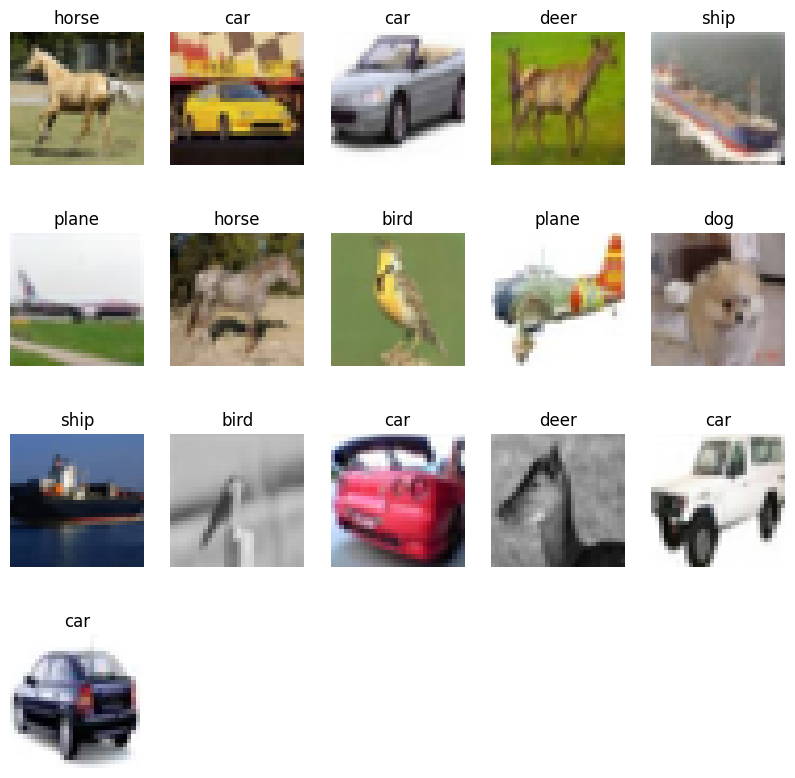

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def display_images_with_labels(images, labels, classes):
    """
    Display images with their corresponding labels.

    Args:
    - images (torch.Tensor): A batch of image tensors.
    - labels (torch.Tensor): A batch of label indices for each image.
    - classes (list of str): Class names for each label index.
    """

    # Determine number of images
    num_images = len(images)

    # Define number of columns for subplots
    ncols = 5
    nrows = num_images // ncols
    nrows += num_images % ncols

    position = range(1, num_images + 1)

    # Create subplots
    fig = plt.figure(figsize=(10, 10))

    for k, (img, label) in enumerate(zip(images, labels)):
        ax = fig.add_subplot(nrows, ncols, position[k])

        # Unnormalize the image
        img = img / 2 + 0.5
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))

        ax.set_title(classes[label])
        ax.axis('off')

    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

display_images_with_labels(images, labels, classes)


## Let's build our Neural Network

This time we build a CNN

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    # counter and accumulator for progress
    self.counter = 0
    self.progress = []

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

    # loss
    self.loss_function = nn.CrossEntropyLoss()

    # optimizer
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.001)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

  def train(self, inputs, targets):

        outputs = self(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()


  def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))



In [7]:
%%time

# create neural network and copy it to GPU
model = CIFAR10Classifier().to(device)

# train network on MNIST data set

epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    # we can iterate through the trainloader and get indivudual batches
    for images, targets in trainloader:
      # we copy images and targets to the gpu while passing them to the train method
      model.train(images.to(device), targets.to(device))



training epoch 1 of 4
counter =  1000
counter =  2000
counter =  3000
training epoch 2 of 4
counter =  4000
counter =  5000
counter =  6000
training epoch 3 of 4
counter =  7000
counter =  8000
counter =  9000
training epoch 4 of 4
counter =  10000
counter =  11000
counter =  12000
CPU times: user 2min 4s, sys: 6.13 s, total: 2min 10s
Wall time: 2min 39s


We can/should save our trained NN

In [9]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

Let's load the test dataset

In [8]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


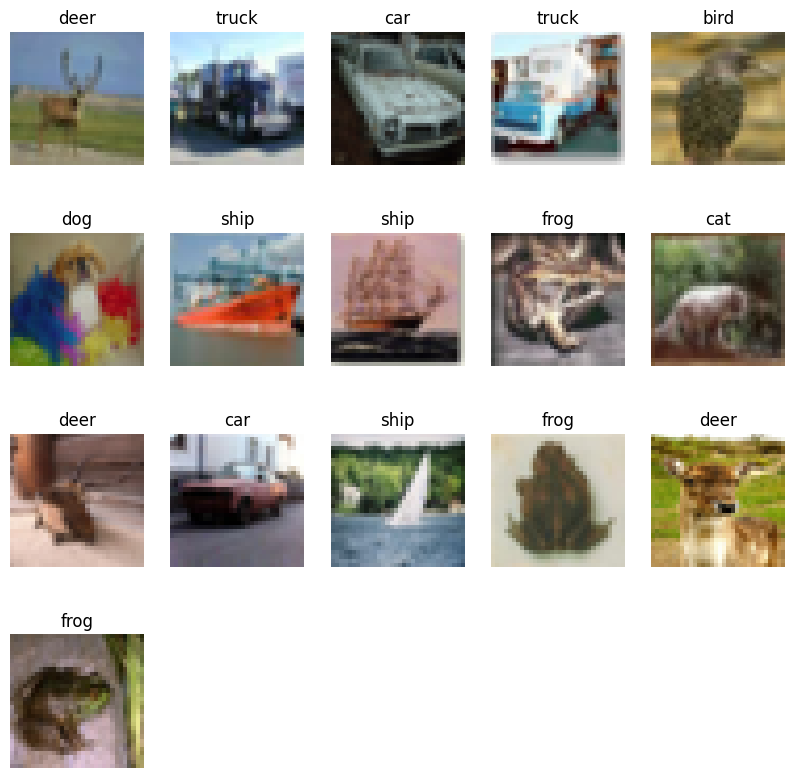

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

display_images_with_labels(images, labels, classes)


As you can see the test images look similar to the training examples but are individually different.

###Load our Model from saved file

In [10]:
loaded_model = CIFAR10Classifier().to(device)
loaded_model.load_state_dict(torch.load(PATH))

<ipython-input-10-c075b84f1919>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [11]:
#generate some predictions
outputs = loaded_model(images.to(device))

In [13]:
 torch.max(outputs, 1)

torch.return_types.max(
values=tensor([2.0140, 3.4788, 2.5869, 5.2011, 2.9619, 1.6923, 3.0715, 2.0996, 2.2008,
        1.2080, 1.7404, 1.2423, 1.4922, 3.6307, 1.6681, 2.4730],
       grad_fn=<MaxBackward0>),
indices=tensor([9, 7, 0, 8, 5, 1, 7, 5, 3, 5, 4, 3, 7, 9, 6, 8]))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Predicted:    deer  truck car   truck deer  dog   ship  truck frog  deer  dog   truck ship  cat   deer  frog 
GroundTruth:  deer  truck car   truck bird  dog   ship  ship  frog  cat   deer  car   ship  frog  deer  frog 


### Test

Let's run the whole test set and calculate the accuracy on the test set

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
      images, labels = data
      # calculate outputs by running images through the network
      outputs = loaded_model(images.to(device))
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.to(device).size(0)
      correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %


As you can see our accuracy is not even near a 100%

Let's see how our model does on each individual class

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = loaded_model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels.to(device), predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 67.0 %
Accuracy for class: car   is 70.6 %
Accuracy for class: bird  is 30.9 %
Accuracy for class: cat   is 40.7 %
Accuracy for class: deer  is 60.4 %
Accuracy for class: dog   is 57.8 %
Accuracy for class: frog  is 62.8 %
Accuracy for class: horse is 62.9 %
Accuracy for class: ship  is 59.8 %
Accuracy for class: truck is 81.0 %
